In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import fb_utils as fb
import time

In [4]:
def tight_flat_spec(w):
    """
    Construction of a tight filterbank with flat spectrum
    :input: analysis filterbank w
    :return: filterbank with flat spectrum
    """
    M, N = w.shape
    w_freqz = np.fft.fft(w,axis=1).T
    w_tight = np.zeros((M, N), dtype=np.complex64)
    for k in range(N):
        H = w_freqz[k, :]
        U = H / np.linalg.norm(H)
        w_tight[:,k] = np.conj(U)
    w_tight = np.fft.ifft(w_tight.T, axis=0).T
    return w_tight

In [5]:
def tight(w):
    """
    Construction of the canonical tight filterbank
    :input: analysis filterbank
    :return: canonical tight filterbank
    """
    w_freqz = np.fft.fft(w,axis=1)
    lp = np.sum(np.abs(w_freqz)**2,axis=0)
    w_freqz_tight = w_freqz * lp**(-0.5)
    return np.fft.ifft(w_freqz_tight,axis=1)

In [70]:
def fir_tight(w, supp, eps=0.01, print_kappa=True):
    """
    Iterative construction of a tight filterbank with a given support
    :param w: analysis filterbank
    :param supp: desired support of the tight filterbank
    :param eps: desired precision for kappa = B/A
    :return: tight filterbank
    """
    A,B = fb.frame_bounds_lp(w)
    w_tight = w.copy()
    kappa = [B/A]
    error = [0]
    it = 0
    if print_kappa:
            print('kappa:', '%.4f' % kappa[it], ', error:', '%.4f' % error[it])
    while B/A > 1+eps:
        it += 1
        w_tight = tight(w_tight)
        w_tight[:,supp:] = 0
        w_tight = np.real(w_tight)
        A,B = fb.frame_bounds_lp(w_tight)
        kappa.append(B/A)
        error.append(np.linalg.norm(w-w_tight)/np.linalg.norm(w))
        if print_kappa:
            print('kappa:', '%.4f' % kappa[it], ', error:', '%.4f' % error[it])
    return w_tight, kappa, error

In [71]:
N = 16000
J = 256
T = 512
w = fb.random_filterbank(N, J, T, tight=False, support_only=False, to_torch=False)

w_tight, kappa, error = fir_tight(w, T, eps=0.01)

kappa: 1.5397 , error: 0.0000
kappa: 1.1817 , error: 0.0264
kappa: 1.1085 , error: 0.0335
kappa: 1.0766 , error: 0.0368
kappa: 1.0581 , error: 0.0387
kappa: 1.0480 , error: 0.0400
kappa: 1.0422 , error: 0.0408
kappa: 1.0374 , error: 0.0415
kappa: 1.0334 , error: 0.0420
kappa: 1.0301 , error: 0.0423
kappa: 1.0273 , error: 0.0427
kappa: 1.0249 , error: 0.0429
kappa: 1.0228 , error: 0.0432
kappa: 1.0210 , error: 0.0434
kappa: 1.0194 , error: 0.0435
kappa: 1.0180 , error: 0.0437
kappa: 1.0168 , error: 0.0438
kappa: 1.0157 , error: 0.0440
kappa: 1.0147 , error: 0.0441
kappa: 1.0141 , error: 0.0442
kappa: 1.0137 , error: 0.0443
kappa: 1.0132 , error: 0.0443
kappa: 1.0128 , error: 0.0444
kappa: 1.0124 , error: 0.0445
kappa: 1.0120 , error: 0.0446
kappa: 1.0116 , error: 0.0446
kappa: 1.0112 , error: 0.0447
kappa: 1.0109 , error: 0.0447
kappa: 1.0106 , error: 0.0448
kappa: 1.0102 , error: 0.0448
kappa: 1.0099 , error: 0.0449


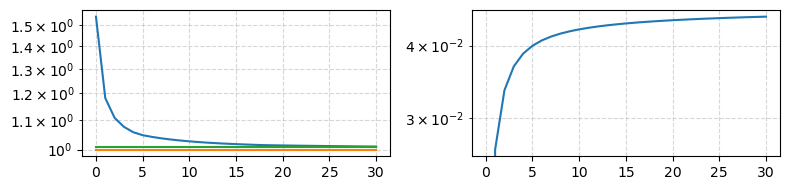

In [72]:
plt.figure(figsize=(8,2))

x = np.arange(len(kappa))

plt.subplot(1,2,1)
plt.plot(x,kappa)
plt.plot(x,np.ones(len(kappa)))
plt.plot(x,np.ones(len(kappa))+0.01)
#plt.xscale('log')
plt.yscale('log')

plt.grid( True, which="both", ls="--",alpha=0.5)

plt.subplot(1,2,2)
plt.plot(x,error[:])
#plt.xscale('log')
plt.yscale('log')

plt.grid( True, which="both", ls="--",alpha=0.5)

plt.tight_layout()
plt.show()

In [166]:
np.random.rand(10)

array([0.41254357, 0.06539097, 0.36818762, 0.05370504, 0.32794962,
       0.33138335, 0.4786528 , 0.20211457, 0.77114914, 0.62342334])

In [172]:
kappa_ill_list = []
error_ill_list = []
num = 100
N = 16000
J = 256
T = 512
for i in range(num):
    c = np.random.rand(J)
    w_ill = np.zeros((J,N))
    for i in range(J):
        w_ill[i,:T] = c[i]**np.arange(T)
    w_tight, kappa, error = fir_tight(w_ill, T, eps=0.01)
    kappa_ill_list.append(kappa)
    error_ill_list.append(error)
# make all kappa lists the same length
max_len = max([len(kappa) for kappa in kappa_ill_list])
for i in range(num):
    if len(kappa_ill_list[i]) < max_len:
        kappa_ill_list[i] = np.append(kappa_ill_list[i],np.ones(max_len-len(kappa_ill_list[i])))
        error_ill_list[i] = np.append(error_ill_list[i],np.zeros(max_len-len(error_ill_list[i])))
kappa_ill_list = np.array(kappa_ill_list)
error_ill_list = np.array(error_ill_list)

kappa_ill_mean = np.mean(kappa_ill_list, axis=0)
kappa_ill_std = np.std(kappa_ill_list, axis=0)
error_ill_mean = np.mean(error_ill_list, axis=0)
error_ill_std = np.std(error_ill_list, axis=0)

kappa: 597.5147 , error: 0.0000
kappa: 5.6809 , error: 0.9774
kappa: 1.8693 , error: 0.9790
kappa: 1.2788 , error: 0.9799
kappa: 1.1045 , error: 0.9803
kappa: 1.0413 , error: 0.9804
kappa: 1.0171 , error: 0.9805
kappa: 1.0074 , error: 0.9805
kappa: 574.9907 , error: 0.0000


KeyboardInterrupt: 

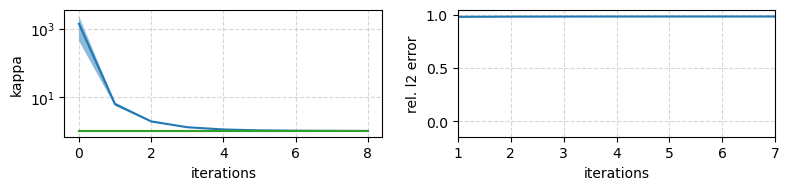

In [97]:
plt.figure(figsize=(8,2))

x = np.arange(len(kappa_ill_mean))

plt.subplot(1,2,1)
plt.plot(x,kappa_ill_mean)
plt.fill_between(x, kappa_ill_mean-kappa_ill_std, kappa_ill_mean+kappa_ill_std, alpha=0.5)
plt.plot(x,np.ones(len(kappa_ill_mean)))
plt.plot(x,np.ones(len(kappa_ill_mean))+0.01)
plt.ylabel('kappa')
plt.xlabel('iterations')
#plt.xscale('log')
plt.yscale('log')

plt.grid( True, which="both", ls="--",alpha=0.5)

plt.subplot(1,2,2)
plt.plot(x,error_ill_mean)
plt.fill_between(x, error_ill_mean-error_ill_std, error_ill_mean+error_ill_std, alpha=0.5)
plt.xlim( 1,7)
plt.ylabel('rel. l2 error')
plt.xlabel('iterations')
#make y axis more readable
#plt.yticks([10**(-3),10**(-2),10**(-1),10**(-0)])
#plt.yscale('log')

plt.grid( True, which="both", ls="--",alpha=0.5)

plt.tight_layout()
plt.show()

In [98]:
kappa_list = []
error_list = []
num = 100
for i in range(num):
    w = fb.random_filterbank(N, J, T, tight=False, support_only=False, to_torch=False)
    w_tight, kappa, error = fir_tight(w, T, eps=0.01)
    kappa_list.append(kappa)
    error_list.append(error)

max_len = max([len(kappa) for kappa in kappa_list])
for i in range(num):
    if len(kappa_list[i]) < max_len:
        kappa_list[i] = np.append(kappa_list[i],np.ones(max_len-len(kappa_list[i])))
        error_list[i] = np.append(error_list[i],np.zeros(max_len-len(error_list[i])))
kappa_list = np.array(kappa_list)
error_list = np.array(error_list)

kappa_mean = np.mean(kappa_list, axis=0)
kappa_std = np.std(kappa_list, axis=0)
error_mean = np.mean(error_list, axis=0)
error_std = np.std(error_list, axis=0)

kappa: 1.4998 , error: 0.0000
kappa: 1.1898 , error: 0.0277
kappa: 1.1150 , error: 0.0350
kappa: 1.0789 , error: 0.0382
kappa: 1.0605 , error: 0.0399
kappa: 1.0483 , error: 0.0411
kappa: 1.0397 , error: 0.0419
kappa: 1.0337 , error: 0.0424
kappa: 1.0290 , error: 0.0429
kappa: 1.0254 , error: 0.0432
kappa: 1.0230 , error: 0.0435
kappa: 1.0210 , error: 0.0437
kappa: 1.0193 , error: 0.0439
kappa: 1.0181 , error: 0.0441
kappa: 1.0171 , error: 0.0443
kappa: 1.0161 , error: 0.0444
kappa: 1.0153 , error: 0.0445
kappa: 1.0146 , error: 0.0446
kappa: 1.0139 , error: 0.0447
kappa: 1.0133 , error: 0.0448
kappa: 1.0127 , error: 0.0448
kappa: 1.0122 , error: 0.0449
kappa: 1.0117 , error: 0.0450
kappa: 1.0113 , error: 0.0450
kappa: 1.0108 , error: 0.0451
kappa: 1.0104 , error: 0.0451
kappa: 1.0101 , error: 0.0452
kappa: 1.0097 , error: 0.0452
kappa: 1.5107 , error: 0.0000
kappa: 1.2097 , error: 0.0269
kappa: 1.1257 , error: 0.0337
kappa: 1.0832 , error: 0.0368
kappa: 1.0633 , error: 0.0385
kappa: 1.0

TypeError: 'other' must be an instance of matplotlib.axes._base._AxesBase, not a bool

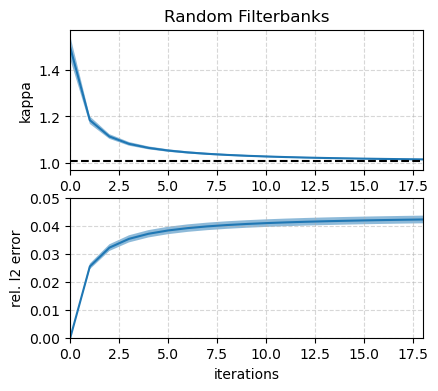

In [140]:
plt.figure(figsize=(10,4))

x = np.arange(len(kappa_mean))

plt.subplot(2,2,1)
plt.plot(x,kappa_mean)
plt.fill_between(x, kappa_mean-kappa_std, kappa_mean+kappa_std, alpha=0.5)
plt.plot(x,np.ones(len(kappa_mean))+0.01, label='kappa=1.01', color='black', linestyle='--')
plt.ylabel('kappa')
plt.xlim( 0,18)
plt.title('Random Filterbanks')

plt.grid( True, which="both", ls="--",alpha=0.5)


plt.subplot(2,2,3)

plt.plot(x,error_mean)
plt.fill_between(x, error_mean-error_std, error_mean+error_std, alpha=0.5)
plt.xlim( 0,18)
plt.ylim( 0,0.05)
plt.ylabel('rel. l2 error')
plt.xlabel('iterations')

plt.grid( True, which="both", ls="--",alpha=0.5)



x = np.arange(len(kappa_ill_mean))

plt.subplot(2,2,2)
plt.plot(x,kappa_ill_mean)
plt.fill_between(x, kappa_ill_mean-kappa_ill_std, kappa_ill_mean+kappa_ill_std, alpha=0.5)
plt.plot(x,np.ones(len(kappa_ill_mean))+0.01, label='kappa=1.01', color='black', linestyle='--')
plt.xlim( 0,7)
plt.title('Ill-coditioned Random Filterbanks')
plt.yscale('log')
plt.grid( True, which="both", ls="--",alpha=0.5)

plt.subplot(2,2,4)
plt.plot(x,error_ill_mean)
plt.fill_between(x, error_ill_mean-error_ill_std, error_ill_mean+error_ill_std, alpha=0.5)
plt.xlim( 0,7)
plt.xlabel('iterations')
plt.ylim( 0,1.2)

plt.grid( True, which="both", ls="--",alpha=0.5)

plt.tight_layout()
plt.show()

In [147]:
supp = 512

with open('audfreqz.npy', 'rb') as f:
    gf = np.load(f)

def gauss(L, sigma):
    g = np.exp(-np.pi * np.arange(-L//2,L//2)**2 / (sigma/2)**2)
    g_c = np.roll(g, L//2)
    return g_c.reshape(1,-1)

w_alt = gauss(16000, 400).reshape(-1,1)
gi = np.fft.ifft(gf, axis=0)
gi_re_supp = np.real(gi[:,:]) * w_alt
W_c = np.concatenate((gi_re_supp[:supp//2], gi_re_supp[-supp//2:]), axis=0).T
W_aud = np.roll(W_c, supp//2, axis=1)
W_aud = np.concatenate((W_aud, np.zeros((W_aud.shape[0],16000-W_aud.shape[1]))), axis=1)

In [149]:
W_aud_tight = fir_tight(W_aud, 512, eps=0.001)

kappa: 4.7525 , error: 0.0000
kappa: 1.0120 , error: 0.6827
kappa: 1.0063 , error: 0.6827
kappa: 1.0051 , error: 0.6827
kappa: 1.0044 , error: 0.6827
kappa: 1.0038 , error: 0.6827
kappa: 1.0034 , error: 0.6827
kappa: 1.0030 , error: 0.6827
kappa: 1.0028 , error: 0.6827
kappa: 1.0025 , error: 0.6827
kappa: 1.0023 , error: 0.6827
kappa: 1.0021 , error: 0.6827
kappa: 1.0020 , error: 0.6827
kappa: 1.0019 , error: 0.6827
kappa: 1.0017 , error: 0.6827
kappa: 1.0016 , error: 0.6827
kappa: 1.0016 , error: 0.6827
kappa: 1.0015 , error: 0.6827
kappa: 1.0014 , error: 0.6827
kappa: 1.0013 , error: 0.6827
kappa: 1.0013 , error: 0.6827
kappa: 1.0012 , error: 0.6827
kappa: 1.0012 , error: 0.6827
kappa: 1.0012 , error: 0.6827
kappa: 1.0011 , error: 0.6827
kappa: 1.0011 , error: 0.6827
kappa: 1.0011 , error: 0.6827
kappa: 1.0010 , error: 0.6827
kappa: 1.0010 , error: 0.6827
kappa: 1.0010 , error: 0.6827


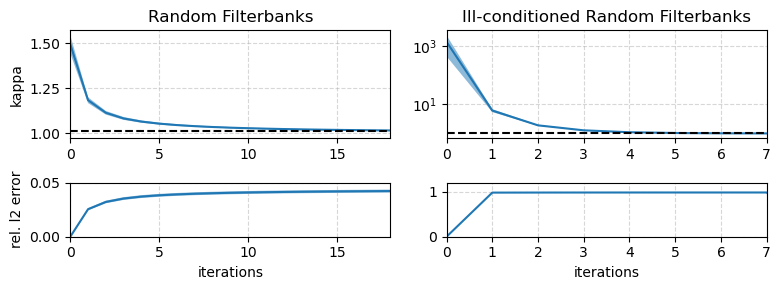

In [159]:
x = np.arange(len(kappa_mean))

# Create a figure and define a 2x2 grid with specific heights and widths
fig, axs = plt.subplots(2, 2, figsize=(8, 3), gridspec_kw={'height_ratios': [2, 1], 'width_ratios': [1, 1]})
fig.tight_layout()

# Random Filterbanks
axs[0, 0].plot(x, kappa_mean)
axs[0, 0].fill_between(x, kappa_mean - kappa_std, kappa_mean + kappa_std, alpha=0.5)
axs[0, 0].plot(x, np.ones(len(kappa_mean)) + 0.01, label='kappa=1.01', color='black', linestyle='--')
axs[0, 0].set_ylabel('kappa')
axs[0, 0].set_xlim(0, 18)
axs[0, 0].set_title('Random Filterbanks')
axs[0, 0].grid(True, which="both", ls="--", alpha=0.5)

axs[1, 0].plot(x, error_mean)
axs[1, 0].fill_between(x, error_mean - error_std, error_mean + error_std, alpha=0.5)
axs[1, 0].set_xlim(0, 18)
axs[1, 0].set_ylim(0, 0.05)
axs[1, 0].set_ylabel('rel. l2 error')
axs[1, 0].set_xlabel('iterations')
axs[1, 0].grid(True, which="both", ls="--", alpha=0.5)

# Ill-conditioned Random Filterbanks
x = np.arange(len(kappa_ill_mean))

axs[0, 1].plot(x, kappa_ill_mean)
axs[0, 1].fill_between(x, kappa_ill_mean - kappa_ill_std, kappa_ill_mean + kappa_ill_std, alpha=0.5)
axs[0, 1].plot(x, np.ones(len(kappa_ill_mean)) + 0.01, label='kappa=1.01', color='black', linestyle='--')
axs[0, 1].set_xlim(0, 7)
axs[0, 1].set_title('Ill-conditioned Random Filterbanks')
axs[0, 1].set_yscale('log')
axs[0, 1].grid(True, which="both", ls="--", alpha=0.5)

axs[1, 1].plot(x, error_ill_mean)
axs[1, 1].fill_between(x, error_ill_mean - error_ill_std, error_ill_mean + error_ill_std, alpha=0.5)
axs[1, 1].set_xlim(0, 7)
axs[1, 1].set_xlabel('iterations')
axs[1, 1].set_ylim(0, 1.2)
axs[1, 1].grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.savefig('FIR_tight.pdf', bbox_inches='tight')
plt.show()


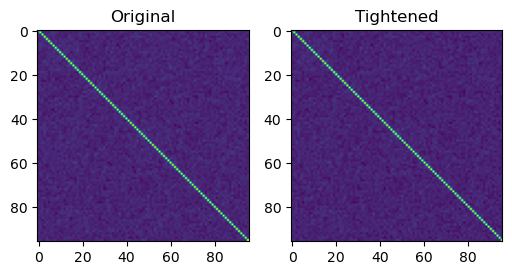

In [50]:
# compute cross-correlation matrix of w_tight
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(np.corrcoef([w[k,1:] for k in range(w.shape[0])] ))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(np.corrcoef([w_tight[k,1:] for k in range(w_tight.shape[0])] ))
plt.title('Tightened')
plt.show()

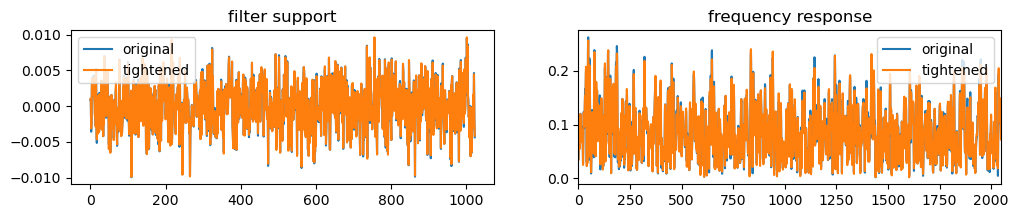

In [51]:
# plot frequency response of w_tight
# 2 plots next to eachother: one for w, one for w_tight

plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(w[0,:T].T, label='original')
plt.plot(w_tight[0,:T].T, label='tightened')
plt.title('filter support')
plt.legend()
plt.subplot(1,2,2)
w_freqz = np.abs(np.fft.fft(w,axis=1).T)
plt.plot(w_freqz[:,0], label='original')
w_tight_freqz = np.abs(np.fft.fft(w_tight,axis=1).T)
plt.plot(w_tight_freqz[:,0], label='tightened')
plt.xlim([0,N//2+1])
plt.title('frequency response')
plt.legend()
plt.show()